* [DCT Denoising](#DCT-Denoising)
* [DnCNN](#DnCNN)
* [DRCN and DCSCN](#DRCN-and-DCSCN)

# DCT Denoising

In [1]:
import tensorflow as tf
import cv2
import scipy
import pickle
import time
from scipy import fftpack as scifft
from PIL import Image
import numpy as np
#import platform
#import tempfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage as ndi
from skimage import io as skio



def idct2_blocks(X):
    O=scifft.idct(X,type=2,axis=0,norm='ortho')
    O=scifft.idct(O,type=2,axis=1,norm='ortho')
    return O
def dct2_blocks(X):
    O=scifft.dct(X,type=2,axis=0,norm='ortho')
    O=scifft.dct(O,type=2,axis=1,norm='ortho')
    return O

class DCT_denoiser():
    def __init__(self,N=7): # N doit etre impaire
        self.N=N
        # calcul des poids de ce reseau
        A=np.zeros((N,N,N**2))
        
        for k in range(N):
            for m in range(N):
                A[k,m,k+m*N]=1.0
        D=idct2_blocks(A)
        iD=np.fliplr(np.flipud(D))
        
        self.seuil=tf.placeholder(tf.float32,shape=())
        self.x=tf.placeholder(tf.float32,[None,None,None,1])
        tr1=tf.nn.conv2d(self.x,D.reshape((N,N,1,N*N)),strides=[1,1,1,1],padding='VALID')    
        cond=tf.less(tf.abs(tr1),self.seuil)
        tr1=tf.where(cond,tf.zeros(tf.shape(tr1)),tr1)
        tr1p=tf.pad(tr1,[[0,0], [N//2,N//2], [N//2,N//2] ,[0,0]],'CONSTANT')
        self.out=tf.nn.conv2d(tr1p,iD.reshape((N,N,N*N,1)),strides=[1,1,1,1],padding='SAME')

    def do_denoise(self,im,s,sess):   
        out=sess.run([self.out],feed_dict={self.x:im.reshape((1,*im.shape,1)),self.seuil:s })        
        return out[0].reshape(im.shape)   
    def get_mask(self,sh): # renvoie le mask par lequel diviser la sortie pour obtenir la vraie restauration
        N=self.N
        sigy=np.concatenate((np.arange(1,N),N*np.ones((sh[0]-2*N+2,)),np.arange(N-1,0,-1))).reshape((sh[0],1))
        sigx= np.concatenate((np.arange(1,N),N*np.ones((sh[1]-2*N+2,)),np.arange(N-1,0,-1))).reshape((1,sh[1]))
        return sigx*sigy

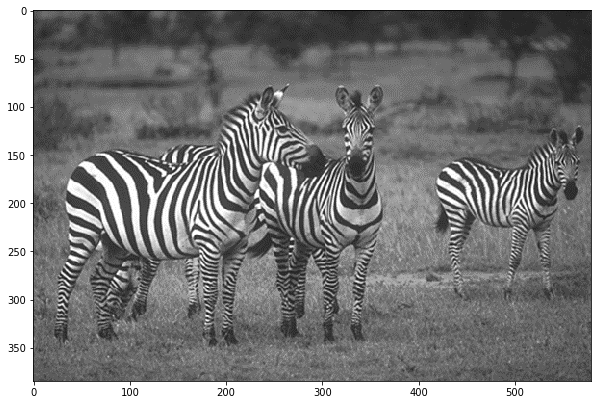

In [2]:
datadir='./data/'
im=np.float32(skio.imread(datadir+'/images_test/zebres.png'))
if len(im.shape)>2: # image couleur
    im=im.sum(axis=2)/3
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray')

In [3]:
sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [89]:
denoiser_dct=DCT_denoiser()
sigma=25
imb=im+sigma*np.random.randn(*im.shape)
out_dct=denoiser_dct.do_denoise(imb,3*sigma,sess)
#mask=denoiser_dct.get_mask(im.shape) # ce mask ne depend que de la taille de l'image
#out_dct=out_dct/mask

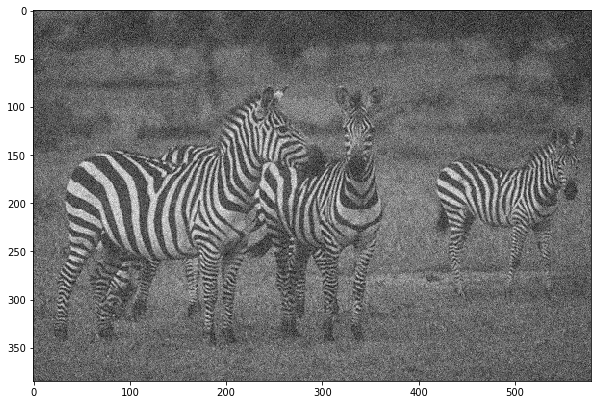

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(imb, cmap='gray')

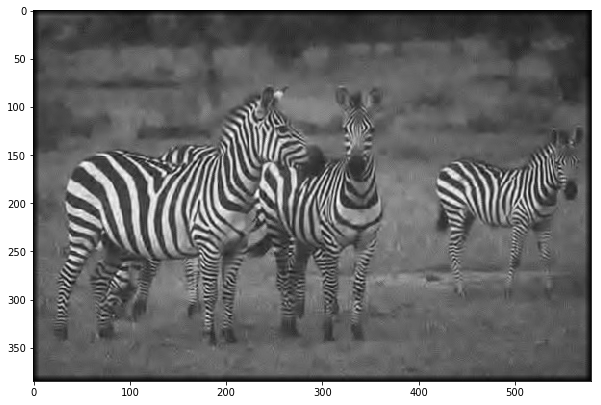

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(out_dct, cmap='gray')

Some experiments to understand what $D$ is:

In [92]:
from scipy.fftpack import idct, idctn, dct, dctn
N=7
A=np.zeros((N,N,N**2))  
for k in range(N):
	for m in range(N):
		A[k,m,k+m*N]=1.0

O=idct(A,type=2,axis=0,norm='ortho')
D=idct(O,type=2,axis=1,norm='ortho')
DD = D.reshape((N,N,1,N*N))

In [93]:
D[:,:,2]

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

In [42]:
idctn(A[0,2].reshape(7,7), type=2, norm='ortho')

array([[ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [-0.20203051, -0.20203051, -0.20203051, -0.20203051, -0.20203051,
        -0.20203051, -0.20203051],
       [-0.12596396, -0.12596396, -0.12596396, -0.12596396, -0.12596396,
        -0.12596396, -0.12596396],
       [ 0.04495602,  0.04495602,  0.04495602,  0.04495602,  0.04495602,
         0.04495602,  0.04495602],
       [ 0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,  0.1820232 ,
         0.1820232 ,  0.1820232 ]])

# DnCNN

In [8]:
modelsdir='./data/models/'

def lecture_poids_DnCNN():
    f=open(modelsdir+'/'+'model_DnCNN_25.pickle','br')
    poids,noms=pickle.load(f)
    f.close()
    return poids

def conv2d_with_bias_relu(inputs,W,B,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")
    return tf.nn.relu(tf.add(conv,B),name=name)

def conv2d_with_bias(inputs,W,B,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")
    return tf.add(conv,B,name=name)

def conv2d_with_normalization_relu(inputs,W,mean,sig,gamma,beta,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")-mean
    conv=tf.add(tf.multiply(tf.divide(conv,(sig)),gamma),beta)
    return tf.nn.relu(conv,name=name)

def tfc(X):
    return tf.constant(X,dtype=tf.float32)

class DnCNN():
    def __init__(self,poids):
        self.noise=25
        self.X=tf.placeholder(tf.float32, [None, None, None, 1],
                                 name='noisy_image')
        inputs=self.X
        self.H=[inputs]
        self.block1=conv2d_with_bias_relu(inputs,tfc(poids[0]),tfc(poids[1]))
        inputs=self.block1
        self.H.append(inputs)
        for k in range(15):
            inputs=conv2d_with_normalization_relu(inputs,tfc(poids[5*k+2]),tfc(poids[5*k+5]),
                                                  tfc(poids[5*k+6]**0.5),tfc(poids[5*k+3]),tfc(poids[5*k+4]),name=('block%d'%k))
            self.H.append(inputs)
        self.H.append(conv2d_with_bias(inputs,tfc(poids[-2]),tfc(poids[-1])))
        self.Y=self.X-self.H[-1]
            
    def do_denoise(self,image,sess,add_noise=False):
        if add_noise:
            imageb=image+np.random.randn(*image.shape)*self.noise
        else:
            imageb=image
        [out]=sess.run([self.Y],feed_dict={self.X:imageb.reshape((1,*image.shape,1))/255.0})
        return 255*(out[0].reshape(image.shape))
    
    def do_denoise_batch(self,images,sess,add_noise=False):
        if add_noise:
            imageb=images+np.random.randn(*images.shape)*self.noise
        else:
            imageb=images
        [out]=sess.run([self.Y],feed_dict={self.X:images/255.0})
        return 255*out[0]


In [94]:
poids=lecture_poids_DnCNN()
denoiser_dncnn=DnCNN(poids)
out_dncnn=denoiser_dncnn.do_denoise(imb,sess)

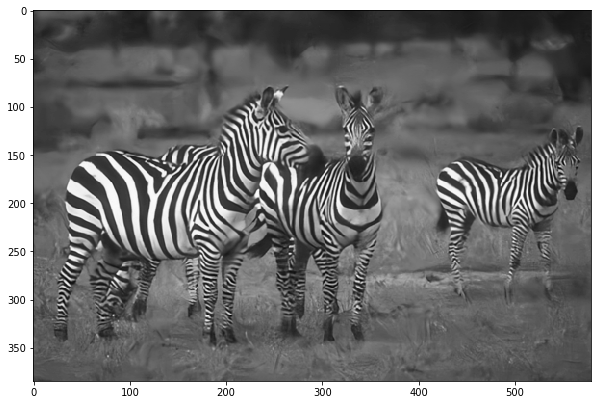

In [95]:
plt.figure(figsize=(10,10))
plt.imshow(out_dncnn, cmap='gray')

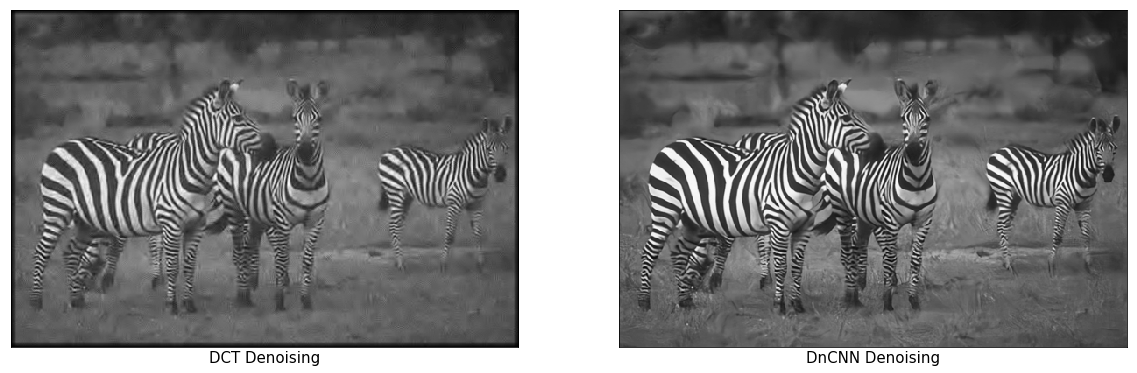

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(out_dct, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("DCT Denoising", fontsize=15)
ax[1].imshow(out_dncnn, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("DnCNN Denoising", fontsize=15)
plt.savefig('plot.eps', bbox_inches='tight')
plt.show()

In [43]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14781d2e8>,
      dtype=object)

In [13]:
3*3*1*64 + 64 + (16-2+1)*(3*3*64*64+64) + 3*3*64*1+1

555137

In [14]:
64*3*3 + 15*64*64*3*3 + 64*3*3

554112

## Retrieving weights

In [31]:
denoiser_dncnn.H

[<tf.Tensor 'noisy_image:0' shape=(?, ?, ?, 1) dtype=float32>,
 <tf.Tensor 'NONAME:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block0:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block1:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block2:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block3:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block4:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block5:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block6:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block7:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block8:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block9:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block10:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block11:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block12:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block13:0' shape=(?, ?, ?, 64) dtype=float32>,
 <tf.Tensor 'block14:0' shape=(?, ?, ?, 64) dtyp

In [85]:
with sess.as_default():
    test = denoiser_dncnn.H[1].eval(feed_dict = {denoiser_dncnn.X:imb.reshape((1,*imb.shape,1))})
    test2 = denoiser_dncnn.H[2].eval(feed_dict = {denoiser_dncnn.X:imb.reshape((1,*imb.shape,1))})

In [33]:
test.shape

(1, 385, 580, 64)

In [86]:
test2.shape

(1, 385, 580, 64)

## Playing around with $\sigma^2$

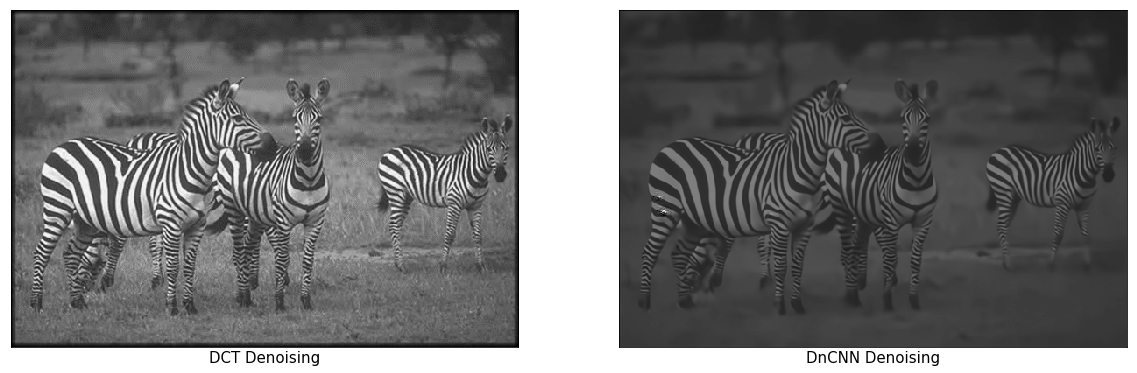

In [99]:
sigma=5
imb=im+sigma*np.random.randn(*im.shape)
out_dct=denoiser_dct.do_denoise(imb,3*sigma,sess)

poids=lecture_poids_DnCNN()
denoiser_dncnn=DnCNN(poids)
out_dncnn=denoiser_dncnn.do_denoise(imb,sess)

fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(out_dct, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("DCT Denoising", fontsize=15)
ax[1].imshow(out_dncnn, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("DnCNN Denoising", fontsize=15)
plt.savefig('plot2.eps', bbox_inches='tight')
plt.show()

# DRCN and DCSCN

In [112]:
def dezoom_brutal(im):
    return im[::2,::2]

def dezoom_cv2(im):
    return cv2.resize(im,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC)

def dezoom_pil(im):
    impil=Image.fromarray(im)
    impil=impil.resize([im.shape[0]//2,im.shape[1]//2],resample=Image.BICUBIC)
    impil=np.asarray(impil)
    return impil 
def zoom_pil(im):
    impil=Image.fromarray(imt)
    impil=impil.resize([2*imt.shape[0],2*imt.shape[1]],resample=Image.BICUBIC)
    imz=np.asarray(impil)
    return imz

def lecture_poids_DRCN():

    f=open(modelsdir+'model_DRCN_9_Z2.pickle','br')
    poids=pickle.load(f)
    f.close()
    return poids

def lecture_poids_DCSCN():
    f=open(modelsdir+'/'+'model_DCSCN_L7.pickle','br')
    poids,noms=pickle.load(f)
    f.close()
    return poids


class DRCN():
    def __init__(self,poids):
        self.recur=9
        self.channels=1
        # la taille du batch et de l'image d'entree est inconnue
        self.x=tf.placeholder(tf.float32, shape=[None, None, None, self.channels], name="X")
        self.Wm1_conv=tf.constant(poids[0]) #m1 signifi etape (-1)
        self.Bm1_conv=tf.constant(poids[1])
        self.Hm1_conv=conv2d_with_bias_relu(self.x,self.Wm1_conv,self.Bm1_conv)
        self.W0_conv=tf.constant(poids[2])
        self.B0_conv=tf.constant(poids[3])
        self.H_conv=(self.recur+1)*[None]
        self.H_conv[0]=conv2d_with_bias_relu(self.Hm1_conv,self.W0_conv,self.B0_conv)
        # On commence la recursion 
        self.W_conv=tf.constant(poids[4])
        self.B_conv=tf.constant(poids[5])
        
        for k in range(self.recur):
            self.H_conv[k+1]= conv2d_with_bias_relu(self.H_conv[k],self.W_conv,self.B_conv) 
        
        # phase de reconstruction 
        # on reconstruit chaque etape recursive de la meme maniere et moyenne avec des poids appris
        self.W=poids[-1] #==poids[10]
        W_sum=self.W.sum()
        self.WD1_conv=tf.constant(poids[6])
        self.BD1_conv=tf.constant(poids[7])
        self.WD2_conv=tf.constant(poids[8])
        self.BD2_conv=tf.constant(poids[9]) # ce 9 n'a rien a voir avec le niveu de recursion...
        self.y_outputs=self.recur*[None] #liste des sorties de chaque etage recursif
        for k in range(self.recur):
            Y1=conv2d_with_bias_relu(self.H_conv[k+1],self.WD1_conv,self.BD1_conv)
            Y1=tf.concat([Y1,self.x],3) # skip connection, on utilise l'image d'entree lors de la reconstruction
            Y2=conv2d_with_bias_relu(Y1,self.WD2_conv,self.BD2_conv)
            self.y_outputs[k]=Y2*self.W[k]/W_sum
        self.y_=tf.add_n(self.y_outputs)
    
    def do_super_resolution(self,image,sess,do_zoom=True):
        sh=image.shape
        shv=[]
        for k in sh:
            if k !=1:
                shv.append(k)
        imt=image.copy().reshape(shv)
        if do_zoom:
            imt=cv2.resize(imt,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
        
        
        out=sess.run([self.y_],feed_dict={self.x: imt.reshape((1,*imt.shape,1))}) # remarquer comme DRCN prend en entree une image zoomee en bicubique. 
        shout=out[0].shape
        
        imt=out[0].reshape((shout[1],shout[2])) #on enleve la dimension batch et canal
        return imt
    
    def do_super_resolution_batch(self,images,sess,do_zoom=True):
        sh=images.shape[1:3]
        
        if do_zoom:
            imz=np.zeros((images.shape[0],2*sh[0],2*sh[0],1))
            for k in range(images.shape[0]):
                imt=images[k,:,:,0]
                imt=cv2.resize(imt,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
                imz[k,:,:,0]=imt
        else:
            imz=images
        
        
        out=sess.run([self.y_],feed_dict={self.x: imz}) # remarquer comme DRCN prend en entree une image zoomee en bicubique. 
        
        return out[0]

In [136]:
poids[8].shape

(3, 3, 97, 1)

In [138]:
9*96 + 9*96**2 + 9**2*96**2 + 9*(9*96**2+9*97) + 9

1584666

In [113]:
# choisir une image 
imoriginal=np.float32(skio.imread(datadir+'Urban100/img_082.png'))
if len(imoriginal.shape)>2:
    imoriginal=imoriginal.sum(axis=2)/3
imdzbrutal=dezoom_brutal(imoriginal)
imdzpil=dezoom_pil(imoriginal)

[]

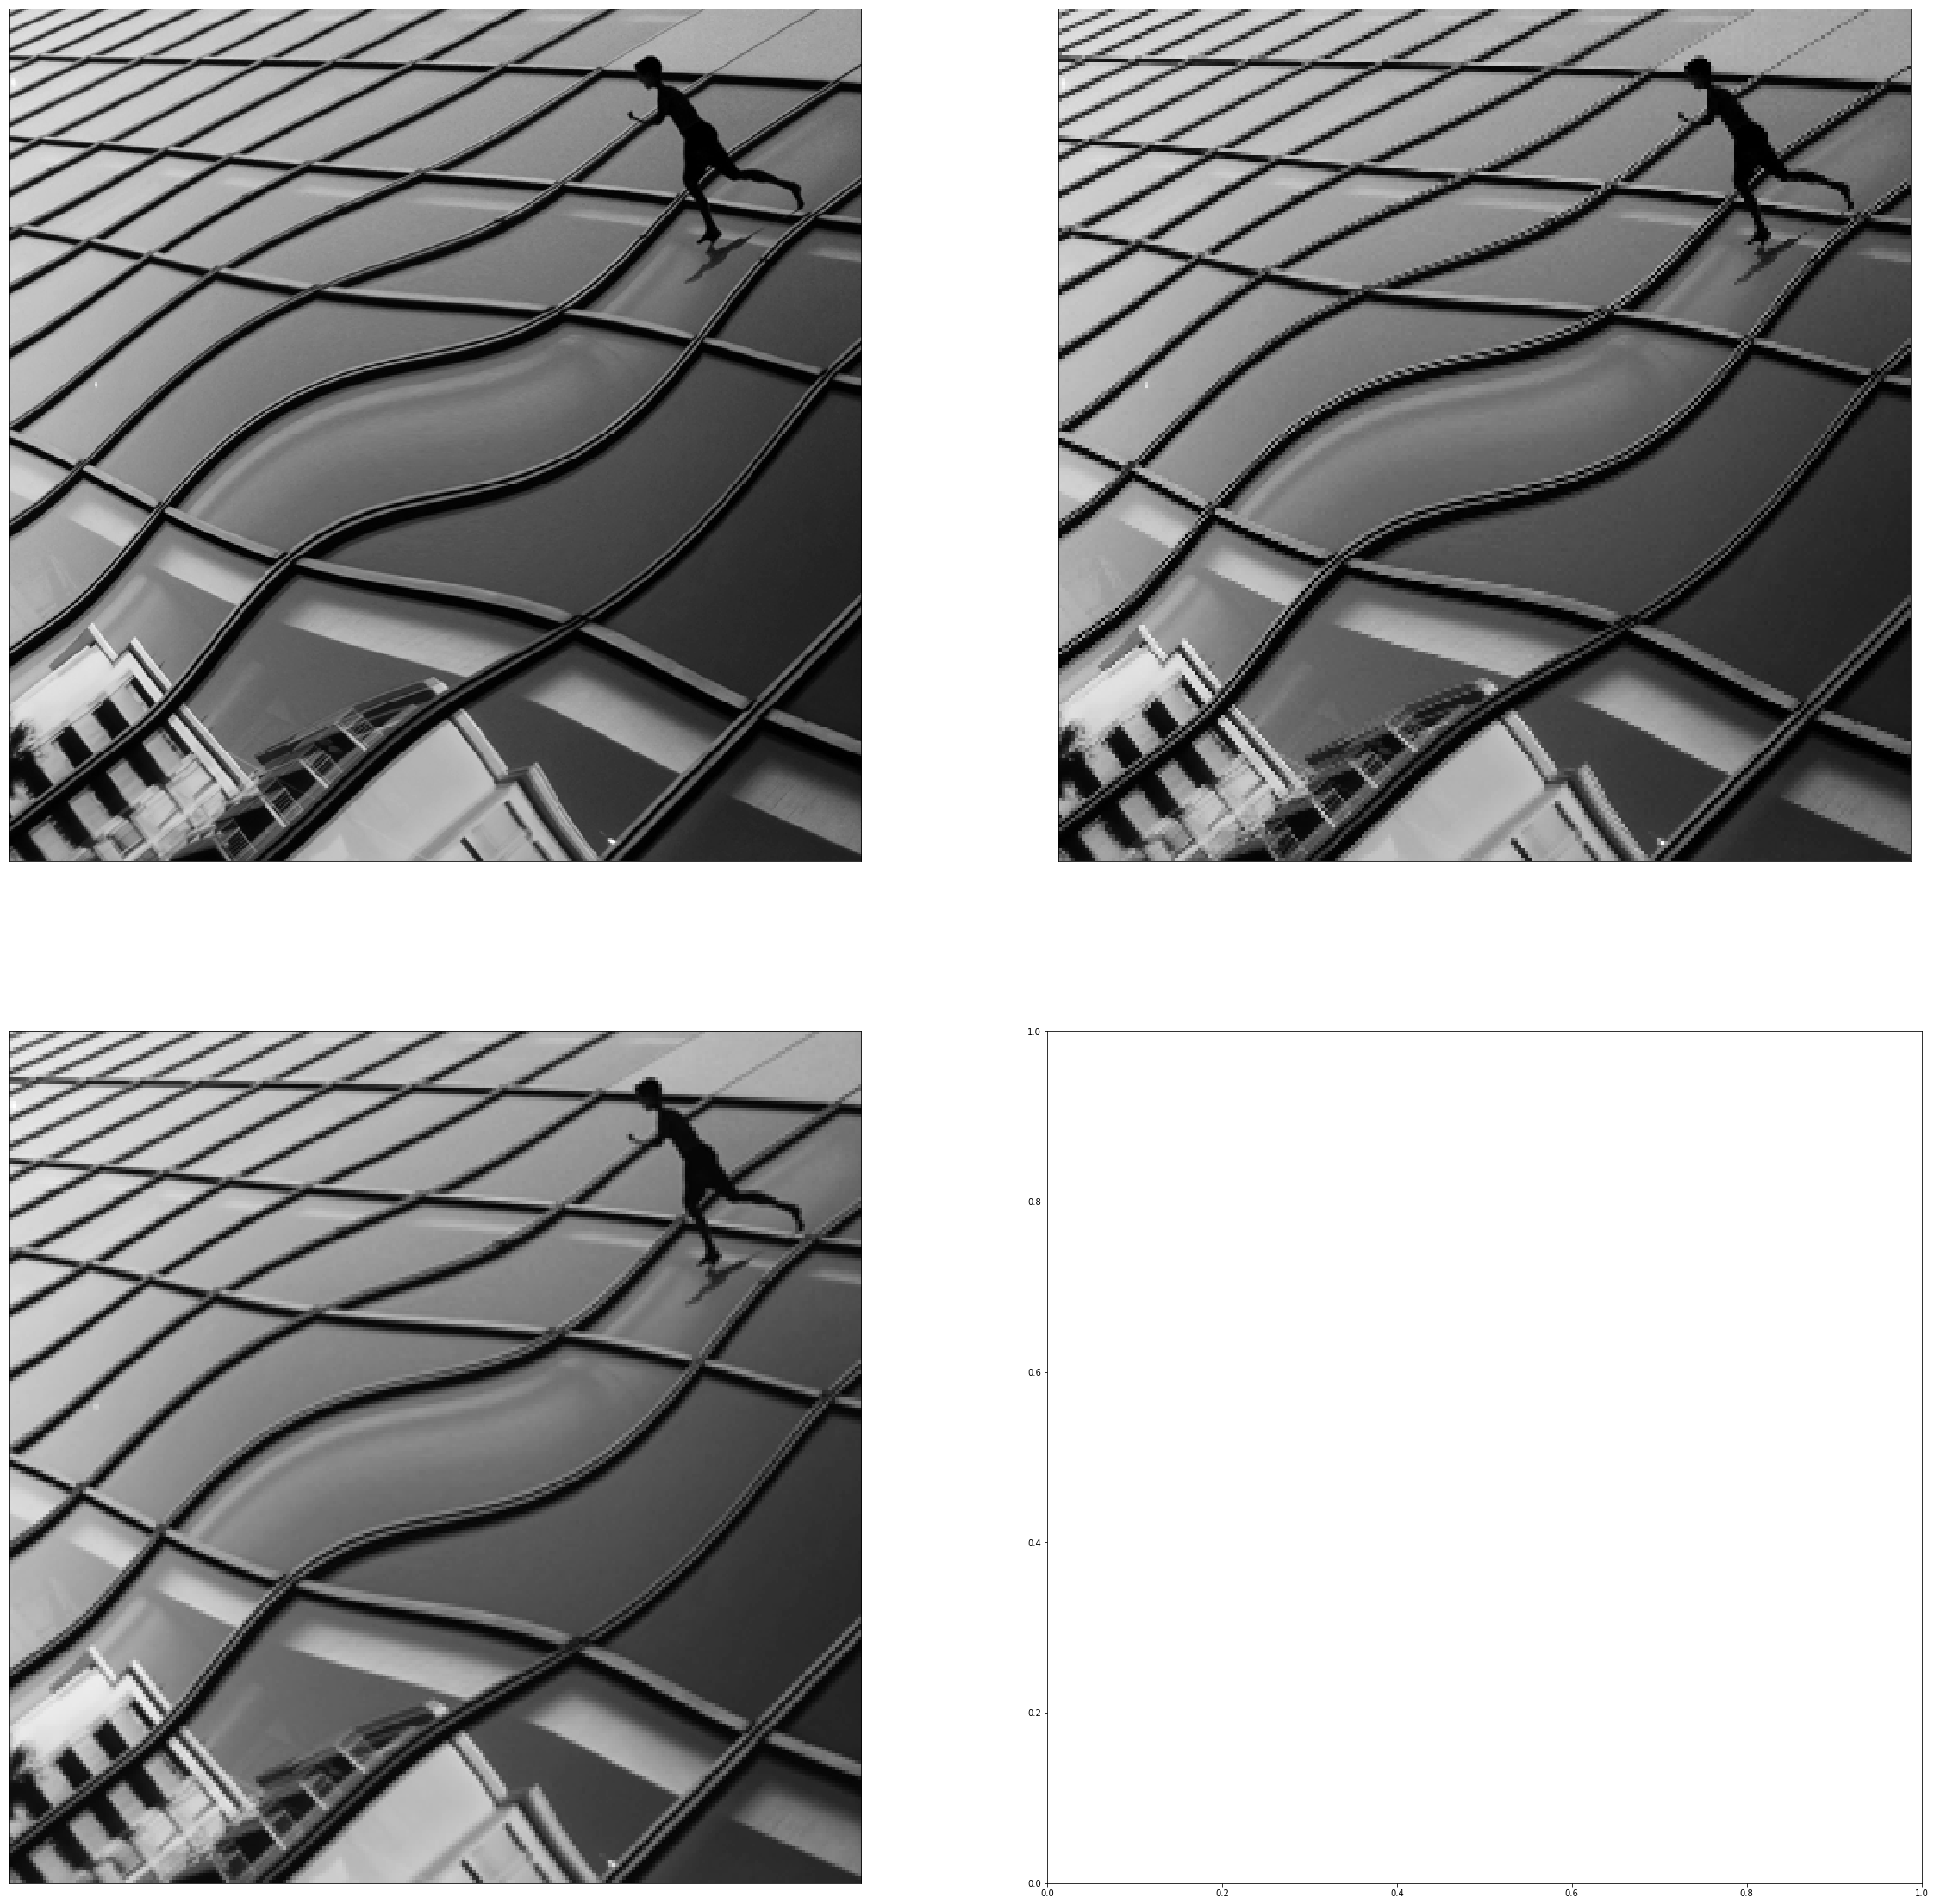

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(40,40))
ax[0,0].imshow(imoriginal, cmap='gray')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].imshow(imdzbrutal, cmap='gray')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].imshow(imdzpil, cmap='gray')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

In [129]:
poids=lecture_poids_DRCN()
instanceDRCN=DRCN(poids)

imzbdrcn=instanceDRCN.do_super_resolution(imdzbrutal,sess)
imzpdrcn=instanceDRCN.do_super_resolution(imdzpil,sess)

Text(0.5, 0, 'pil puis DRCN')

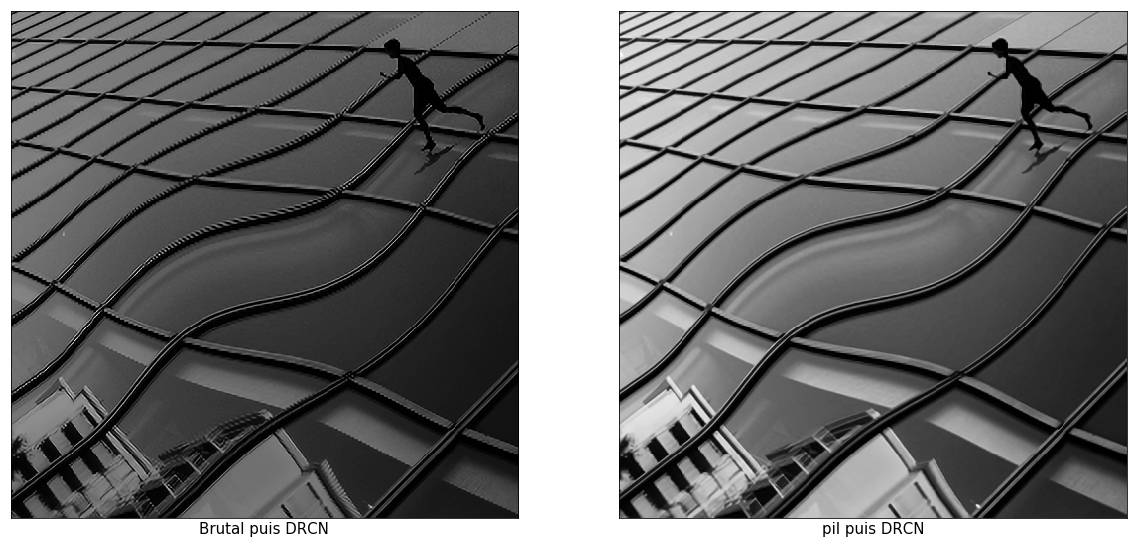

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(imzbdrcn, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("Brutal puis DRCN", fontsize=15)
ax[1].imshow(imzpdrcn, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("pil puis DRCN", fontsize=15)

In [208]:
image = imdzpil
sh=image.shape
shv=[]
for k in sh:
    if k !=1:
        shv.append(k)
imt=image.copy().reshape(shv)
imt=cv2.resize(imt,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
images = []
with sess.as_default():
    for i in range(9):
        images.append(instanceDRCN.H_conv[i].eval(feed_dict={instanceDRCN.x: imt.reshape((1,*imt.shape,1))}))


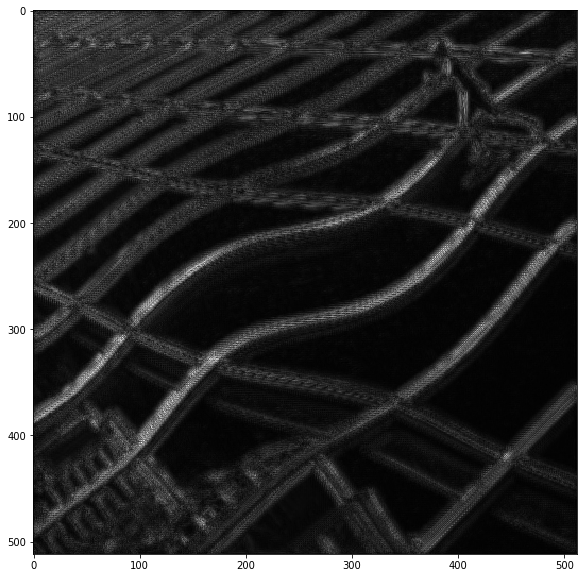

In [231]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(images[8],3)[0,:,:], cmap='gray')

In [119]:
def conv2d_with_bias_prelu(inputs,W,B,P,name='NONAME'):
    conv=tf.nn.conv2d(inputs,W,strides=[1,1,1,1],padding="SAME")
    tmp=tf.add(conv,B)
    return tf.add(tf.nn.relu(tmp),tf.multiply(P,0.5*(tmp-tf.abs(tmp))),name=name)

#DCSCN
class DCSCN():
    def __init__(self,poids):
        self.scale=2
        self.number_layers=7
        self.x=tf.placeholder(tf.float32, shape=[None, None, None, 1], name="x")
        self.y = tf.placeholder(tf.float32, shape=[None, None, None, 1], name="y")
        self.x2 = tf.placeholder(tf.float32, shape=[None, None, None, 1], name="x2") #image zoomee en bicubique
        self.H=[self.x]
        for k in range(self.number_layers):
            self.H.append(conv2d_with_bias_prelu(self.H[-1],poids[k*3],poids[3*k+1],poids[3*k+2]))
        self.H_concat=tf.concat(self.H[1:],3,name="H_concat")
        self.H.append(conv2d_with_bias_prelu(self.H_concat,poids[21],poids[22],poids[23],name='A1'))
        self.H.append(conv2d_with_bias_prelu(self.H_concat,poids[24],poids[25],poids[26],name='B1'))
        self.H.append(conv2d_with_bias_prelu(self.H[-1],poids[27],poids[28],poids[29],name='B2'))
        self.H.append(tf.concat([self.H[-1],self.H[-3]],3,name="concat2"))
        self.H.append(tf.depth_to_space(conv2d_with_bias_relu(self.H[-1],poids[30],poids[31]),2,name='changement_de_taille'))
        self.H.append(tf.nn.conv2d(self.H[-1],poids[32],strides=[1,1,1,1],padding="SAME",name='RECONSTRUCTION'))
        self.y_=tf.add(self.H[-1],self.x2,name="final_output")

    
    def do_super_resolution(self,image,sess):
        sh=image.shape
        shv=[]
        for k in sh:
            if k !=1:
                shv.append(k)
        imt=image.copy().reshape(shv)

        impil=Image.fromarray(imt)
        impil=impil.resize([2*imt.shape[0],2*imt.shape[1]],resample=Image.BICUBIC)
        imz=np.asarray(impil)
#        imz
#        imz=cv2.resize(imt,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
        
        out=sess.run([self.y_],feed_dict={self.x2:imz.reshape((1,*imz.shape,1)), self.x: imt.reshape((1,*imt.shape,1))}) # remarquer comme DRCN prend en entree une image zoomee en bicubique. 
        shout=out[0].shape
        
        imt=out[0].reshape((shout[1],shout[2])) #on enleve la diomension batch et canal
        return imt
    
    def do_super_resolution_batch(self,images,sess,do_zoom=True):
        sh=images.shape[1:3]
        

        imz=np.zeros((images.shape[0],2*sh[0],2*sh[0],1))
        for k in range(images.shape[0]):
            
            imt=cv2.resize(images[k,:,:,0],None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
            imz[k,:,:,0]=imt
        
        
        
        out=sess.run([self.y_],feed_dict={self.x2:imz, self.x: images}) # remarquer comme DRCN prend en entree une image zoomee en bicubique. 
        
        return out[0]

In [182]:
9*(32+32*26+26*22+22*18+18*14+14*11+11*8) + 131*24 + 131*8 + 9*8*8 + 9*32*128 + 9*4*32

63718

In [183]:
poids=lecture_poids_DCSCN()
instanceDCSCN=DCSCN(poids)

imzbdcscn=instanceDCSCN.do_super_resolution(imdzbrutal/255,sess)
imzcdcscn=instanceDCSCN.do_super_resolution(imdzpil,sess)

Text(0.5, 0, 'pil puis DCSCN')

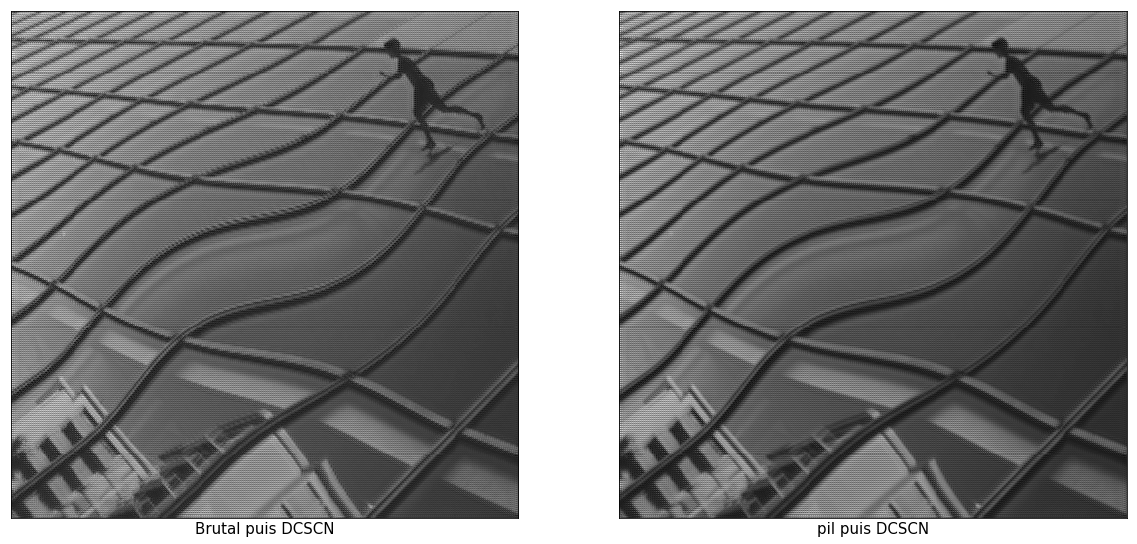

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(imzbdcscn, cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("Brutal puis DCSCN", fontsize=15)
ax[1].imshow(imzcdcscn, cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("pil puis DCSCN", fontsize=15)

In [122]:
imdzpil.shape

(256, 256)

In [123]:
imzcdcscn.shape

(512, 512)